In [1]:
from utils.dataset import CTMaskDataset
from utils.utils import  plotSomeImages, generateNpySlices, loadMatData, generateSplits
from predict import predict_vol_from_vol_idx
from unet.unet_model import UNet
from random import randint
from eval import eval_volumes
import torch
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from PIL import Image

## Create training data.

In [2]:
# Create list of patient [vol_idxs] from range.
all_idxs = [[a , b] for b in range(1,4) for a in range(1,10)]
# Create list of the class mask_data you want.
mask_names = ['spine_mask', 'stern_mask', 'pelvi_mask']
# Generate training/data splits from those that have .mat data matching the mask_names. 
val_idxs, trn_idxs = generateSplits(all_idxs, mask_names = mask_names)
# Generate the training .npy files.
generateNpySlices(trn_idxs[0], mask_names = mask_names, plane = 'coronal')

## Verify training data.

In [151]:
# Create a CTMaskDataset from the training data.
dataset = CTMaskDataset(augment=True, plane='coronal')

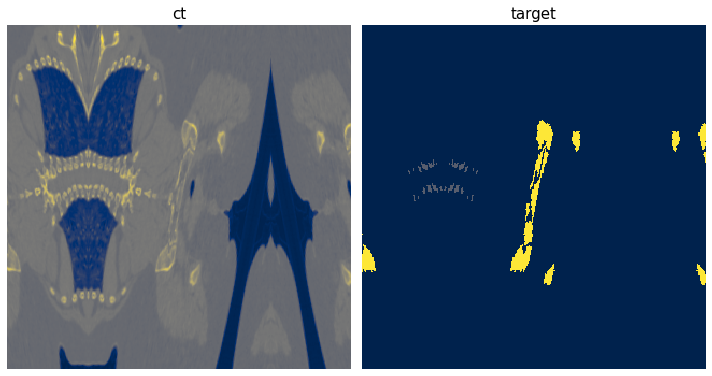

In [181]:
# Display a sample from the training data. 
ridx = randint(0, len(dataset))
verify = dataset[ridx]
ct = verify['ct'].squeeze().numpy()
target = verify['target'].squeeze().numpy()
imgs = {'ct': ct, 'target': target}
plotSomeImages(imgs, 1, 2)

## Evaluate model on vol_idxs

In [ ]:
# Set up UNet. Must match model you are loading. 
device = torch.device('cuda')
# n_classes = 1 for binary class, n+1 for multi-class.
net = UNet(n_channels=1, n_classes=4, bilinear=False) 
# Load model from file.
net.load_state_dict(torch.load('C:/.py_workspace/reveal/unet2D/.runs/multiclass_testing/3class_results/model_state.pth'))
net.to(device)

In [ ]:
# Evaluate from vol_idx list!
vol_idxs = [[2, 1], [2, 3]]
eval_volumes(net, device, vol_idxs)

## Generate prediction volume from model.

In [ ]:
# Set up UNet. Must match model you are loading. 
device = torch.device('cuda')
# n_classes = 1 for binary class, n+1 for multi-class.
net = UNet(n_channels=1, n_classes=4, bilinear=False) 
# Load model from file.
net.load_state_dict(torch.load('C:/.py_workspace/reveal/unet2D/.runs/multiclass_testing/3class_results/model_state.pth'))
net.to(device)

In [ ]:
# Predict from vol_idx!
vol_idx = [22, 3]
ct_data = loadMatData(vol_idx, data = 'ct')
pt_data = loadMatData(vol_idx, data = 'pt')
with torch.no_grad():
    pred_vol = predict_vol_from_vol_idx(net, device, vol_idx)

In [ ]:
# Save as .mat if you want...
# Something like this (for "3 class" model)...
pred_dict = {'bg': pred_vol[0, :, :, :],
             'spine': pred_vol[1, :, :, :],
             'stern': pred_vol[2, :, :, :],
             'pelvi': pred_vol[3, :, :, :]}

savepath = "C:/.py_workspace/reveal/unet2D/.predictions/"
filename = "patient%d_day%d_pred.mat" % (vol_idx[0], vol_idx[1])
sp.io.savemat(savepath + filename, pred_dict, do_compression=True)

## Slice Display Stuff

In [ ]:
vol_idx = [2, 2]
ct = loadMatData(vol_idx)
pt = loadMatData(vol_idx, data = 'pt')

device = torch.device('cuda')
net = UNet(n_channels=1, n_classes=4, bilinear=False) 
net.load_state_dict(torch.load('C:/.py_workspace/reveal/unet2D/.runs/multiclass_testing/3class_results/model_state.pth'))
net.to(device)
mask = predict_vol_from_vol_idx(net, device, vol_idx)[1]

ct_sag = np.flip(np.transpose(ct[:, 255, :]), 0)
height, width = np.shape(ct_sag)
ct_sag_pil = Image.fromarray(ct_sag)
ct_sag_pil = ct_sag_pil.resize((width, 3 * height), resample = Image.NEAREST)
ct_sag = np.array(ct_sag_pil)

ct_cor = np.flip(np.transpose(ct[315, :, :]), 0)
height, width = np.shape(ct_cor)
ct_cor_pil = Image.fromarray(ct_cor)
ct_cor_pil = ct_cor_pil.resize((width, 3 * height), resample = Image.NEAREST)
ct_cor = np.array(ct_cor_pil)

pt_sag = np.flip(np.transpose(pt[:, 255, :]), 0)
height, width = np.shape(pt_sag)
pt_sag_pil = Image.fromarray(pt_sag)
pt_sag_pil = pt_sag_pil.resize((width, 3 * height), resample = Image.NEAREST)
pt_sag = np.array(pt_sag_pil)

pt_cor = np.flip(np.transpose(pt[315, :, :]), 0)
height, width = np.shape(pt_cor)
pt_cor_pil = Image.fromarray(pt_cor)
pt_cor_pil = pt_cor_pil.resize((width, 3 * height), resample = Image.NEAREST)
pt_cor = np.array(pt_cor_pil)

mask_sag = np.flip(np.transpose(mask[:, 255, :]), 0)
height, width = np.shape(mask_sag)
mask_sag_pil = Image.fromarray(mask_sag)
mask_sag_pil = mask_sag_pil.resize((width, 3 * height), resample = Image.NEAREST)
mask_sag = np.array(mask_sag_pil)

mask_cor = np.flip(np.transpose(mask[315, :, :]), 0)
height, width = np.shape(mask_cor)
mask_cor_pil = Image.fromarray(mask_cor)
mask_cor_pil = mask_cor_pil.resize((width, 3 * height), resample = Image.NEAREST)
mask_cor = np.array(mask_cor_pil)

pt_sag_seg = pt_sag * mask_sag
pt_cor_seg = pt_cor * mask_cor

images = {'ct_sagital': ct_sag, 
          'pet_sagital': pt_sag,
          'mask_sagital': mask_sag,
          'pet_sag_seg': pt_sag_seg, 
          'ct_coronal': ct_cor,
          'pet_coronal': pt_cor,
          'mask_coronal': mask_cor,
          'pet_cor_seg': pt_cor_seg}
plotSomeImages(images, nrows = 2, ncols = 4)